<a href="https://colab.research.google.com/github/DarshanGowda0/MusicalInstrumentsClassification/blob/main/MFCC_Autoencoder_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.35.14.66:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.35.14.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.14.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
le = LabelEncoder()

# tf.config.experimental_run_functions_eagerly(True)

!pip install --upgrade tables

df = pd.read_hdf('/content/drive/MyDrive/mfcc-16-128-and-other-features.h5', key='s', mode='r')

     |████████████████████████████████| 4.3MB 5.1MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

INSTRUMENTS = ['flu', 'pia', 'tru', 'gac', 'voi', 'org']
df = df.loc[df['label'].isin(INSTRUMENTS)]


In [ ]:
mfcc, other_features, y = df['mfcc'], df.values[:, 1:-1], df['label']
print(mfcc.shape)
y_cat = le.fit_transform(y)
X = np.stack([x for x in mfcc])
X = np.expand_dims(X, axis=-1)

(3846,)


In [ ]:
np.isnan(X).any()
# print(X.shape)
# X = (X - X.mean(axis=(0,1,2), keepdims=True)) / X.std(axis=(0,1,2), keepdims=True)

False

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.30)

In [ ]:
orig_dim = np.product(X_train.shape[1:])
enc_dim = int(0.10 * orig_dim)
print(orig_dim, enc_dim)

2048 204


In [ ]:
train_reshaped, val_reshaped = X_train.reshape(X_train.shape[0], np.product(X_train.shape[1:])), X_test.reshape(X_test.shape[0], np.product(X_test.shape[1:]))
print(train_reshaped.shape, val_reshaped.shape)

(2692, 2048) (1154, 2048)


In [ ]:
def create_model(original_dim, encoded_dim):
  input_img = layers.Input(shape=(original_dim,))
  encoded = layers.Dense(encoded_dim, activation='relu')(input_img)
  # encoded = layers.Dense(int(0.6 * original_dim), activation='relu')(encoded)
  # encoded = layers.Dense(int(0.5 * original_dim), activation='relu')(encoded)

  # decoded = layers.Dense(int(0.6 * original_dim), activation='sigmoid')(encoded)
  # decoded = layers.Dense(int(0.8 * original_dim), activation='sigmoid')(decoded)
  decoded = layers.Dense(int(original_dim))(encoded)

  # model
  autoencoder = keras.Model(input_img, decoded)

  # compile
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['acc'])

  #encoder
  encoder = keras.Model(input_img, encoded)

  # decoder
  encoded_input = keras.Input(shape=(encoded_dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
  
  return autoencoder, encoder, decoder

In [ ]:
with tpu_strategy.scope():
  model, encoder, decoder = create_model(orig_dim, enc_dim)
  model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 204)               417996    
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              419840    
Total params: 837,836
Trainable params: 837,836
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_reshaped, train_reshaped, epochs=300, batch_size=64, validation_data=(val_reshaped, val_reshaped))

Epoch 1/300
43/43 [==============================] - 6s 78ms/step - loss: 4968.5857 - acc: 0.0029 - val_loss: 2303.1792 - val_acc: 0.0078
Epoch 2/300
43/43 [==============================] - 1s 32ms/step - loss: 1548.5923 - acc: 0.0082 - val_loss: 605.0480 - val_acc: 0.0078
Epoch 3/300
43/43 [==============================] - 1s 31ms/step - loss: 578.6140 - acc: 0.0045 - val_loss: 454.6880 - val_acc: 0.0095
Epoch 4/300
43/43 [==============================] - 1s 30ms/step - loss: 432.4952 - acc: 0.0055 - val_loss: 388.8611 - val_acc: 0.0147
Epoch 5/300
43/43 [==============================] - 1s 34ms/step - loss: 372.8382 - acc: 0.0080 - val_loss: 356.8599 - val_acc: 0.0139
Epoch 6/300
43/43 [==============================] - 1s 30ms/step - loss: 351.4280 - acc: 0.0078 - val_loss: 339.8532 - val_acc: 0.0121
Epoch 7/300
43/43 [==============================] - 1s 30ms/step - loss: 327.8178 - acc: 0.0042 - val_loss: 326.5372 - val_acc: 0.0130
Epoch 8/300
43/43 [==========================

loss: 53.34902572631836
val_loss: 63.61843490600586


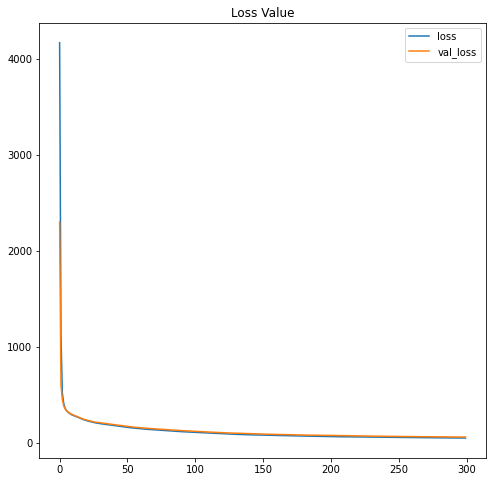

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])

acc: 0.12407132238149643
val_acc: 0.10051993280649185


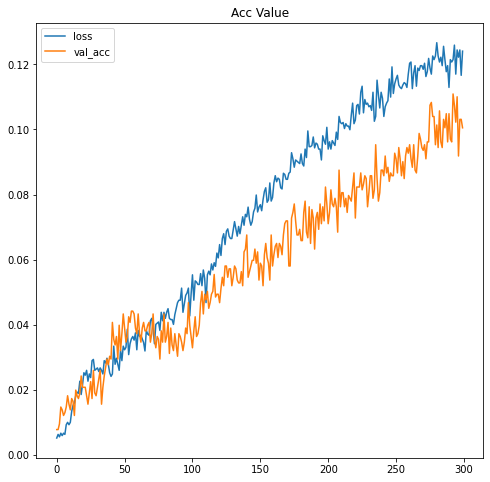

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title('Acc Value')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['loss', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])

In [ ]:
encoded_mfcc = encoder.predict(val_reshaped)
decoded_mfcc = decoder.predict(encoded_mfcc)

In [ ]:
decoded_mfcc.shape
# np.isnan(decoded_mfcc).any()

(1154, 2048)

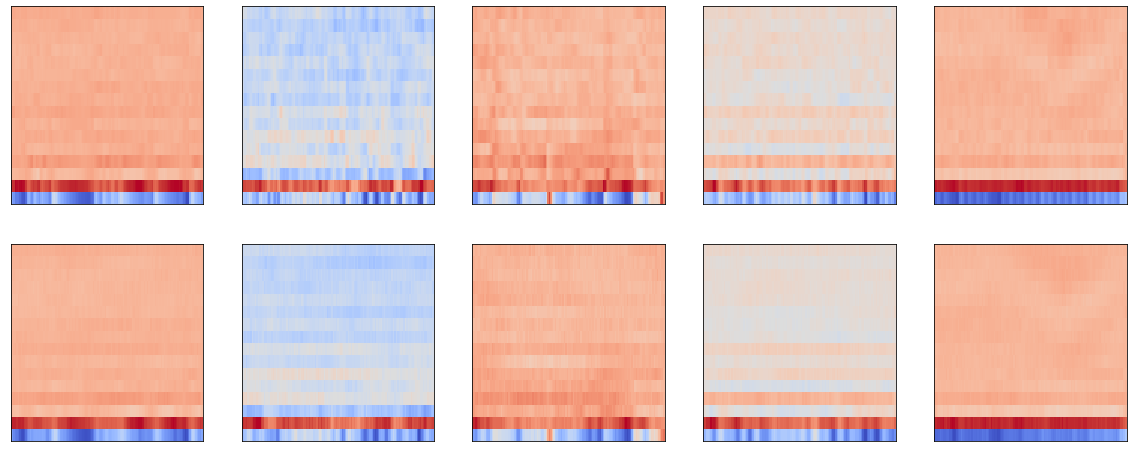

In [ ]:
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    librosa.display.specshow(val_reshaped[i].reshape(X.shape[1:3]).T, sr=22050)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    librosa.display.specshow(decoded_mfcc[i].reshape(X.shape[1:3]).T, sr=22050)
plt.show()

In [ ]:
val_reshaped.shape

(1154, 2048)

In [ ]:
X.shape

(3846, 128, 16, 1)

In [ ]:
original_X_reshaped = X.reshape((X.shape[0], np.product(X.shape[1:])))
original_X_reshaped.shape
np.isnan(original_X_reshaped).any()

False

In [ ]:
reduced_X = encoder.predict(original_X_reshaped)

In [ ]:
print(reduced_X.shape, np.isnan(reduced_X).any())
all_features = np.hstack((reduced_X, other_features))

(3846, 204) False


In [ ]:
reduced_df = pd.DataFrame(zip(reduced_X, y), columns=['encoder_features', 'label'])
reduced_df.to_hdf('/content/drive/MyDrive/mfcc-autoencoder-simple-reduced-10percent.h5', key='s', mode='w')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['encoder_features', 'label'], dtype='object')]

  encoding=encoding,
